<a href="https://colab.research.google.com/github/juliaviolet/Python_Options/blob/main/Heston_Calibration_Numba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


The **Heston (H93)** model is characterized by the following SDEs:

\begin{align*}
dS_t &= r S_t dt + \sqrt{v_t} S_t dW_{1,t} \\
dv_t &= \kappa_v (\theta_v - v_t) dt + \sigma_v \sqrt{v_t} dW_{2,t}
\end{align*}

Where $W_{1,t} $ and $W_{2,t} $ are correlated Brownian motions with correlation $\rho $.

The characteristic function $ \Phi(u, t; x) $ of the log stock price is given by:

$
\Phi(u, t; x) = \exp \left( \text{H}_1 + \text{H}_2 v_0 \right)
$

Where:

$
\begin{align*}
\text{H}_1 &= r u i t + \frac{\kappa_v \theta_v}{\sigma_v^2} \left[ (\kappa_v - \rho \sigma_v ui + c2) t - 2 \ln \left( \frac{1 - c3 e^{c2 t}}{1 - c3} \right) \right] \\
\text{H}_2 &= \frac{\kappa_v - \rho \sigma_v ui + c2}{\sigma_v^2} \left[ \frac{1 - e^{c2 t}}{1 - c3 e^{c2 t}} \right]
\end{align*}
$

And:

$
\begin{align*}
c1 &= \kappa_v \theta_v \\
c2 &= \sqrt{ (\rho \sigma_v ui - \kappa_v)^2 + \sigma_v^2 (ui + u^2) } \\
c3 &= \frac{\kappa_v - \rho \sigma_v ui + c2}{\kappa_v - \rho \sigma_v ui - c2}
\end{align*}
$

The option prices are determined by the integral of a function involving the characteristic function.


For a call option in the H93 model, the price is:

$
C_0 = \max \left( 0, S_0 - \exp(-r T) \frac{\sqrt{S_0 K}}{\pi} \int_0^{\infty} \text{Re} \left( \frac{\exp \left( iu \ln(S_0 / K) \right) \Phi_T(u - i/2)}{u^2 + 0.25} \right) du \right)
$

The parameters are calibrated by minimizing the squared difference between observed market prices and model prices.


**Understanding of Topics and Tools Demonstrated in the Code**

1. **Loading Libraries & Data**:
   - `numpy`, `pandas`, `scipy.integrate`, and `scipy.optimize` are imported.
   - Option data is loaded from the file `sorted_options_data.csv`, and the first row is discarded. The time to expiration for each option is computed.

2. **Heston Model Functions**:
   - The integral and characteristic functions for the model are defined.
   - Functions to compute call and put option prices are also specified. The put prices are derived from the put-call parity principle.

3. **Calibration**:
   - An objective function is defined to minimize the sum of squared differences between the model prices and the observed market prices.
   - Initial parameter guesses and their bounds are set.
   - A function `process_batch` is formulated to calibrate the model parameters for both call and put options, based on a specific implied volatility range.

4. **Pricing with Calibrated Parameters**:
   - Using an example implied volatility range of 23, parameters are calibrated.
   - Options within this range are then priced using the calibrated parameters.

5. **Output**:
   - The data frame containing option details and model prices is printed.
   - This data is stored in a CSV file.

**Strengths**:

1. **Thorough Implementation**: The code encompasses data preprocessing, defining the Heston model, calibrating parameters, and pricing options.
2. **Flexibility**: The code is designed to handle different implied volatility ranges, making it versatile for various datasets.
3. **Optimized Calibration**: The calibration efficiently employs the SLSQP method from SciPy.
**Weaknesses**:

1. **Potential Errors in Model Assumptions**: Assumes that volatility follows a mean-reverting process, which may not always be valid in real-world markets.
2. **Hardcoded Risk-Free Rate**: The risk-free rate is hardcoded, potentially making it non-representative for all datasets or time periods.
3. **Inefficient Looping**: The code uses `iterrows()` to loop over DataFrame rows, which is inefficient for large datasets. Vectorized operations or the `apply` method would be more optimal.
4. **Limited Error Handling**: Comprehensive error handling is missing. For instance, if the input data lacks certain columns, the code will crash.
5. **Code Reusability**: Similar blocks for call and put option calibrations could be refactored to improve maintainability and reduce redundancy.

In [2]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.integrate import quad
from scipy.optimize import minimize

#Defining the required functions for the Heston (H93) model
# Valuation of European Call and Put Options
# Under Stochastic Volatility and Jumps
# 09_gmm/BCC_option_valuation.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python

def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    int_value = quad(lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0), 0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

def H93_put_value(C, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    C = H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    return C - S0 + K * np.exp(-r * T)

@njit
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    char_func_value = H93_char_func(u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    int_func_value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

@njit
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v ** 2 * (-u * 1j - u ** 2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = (r * u * 1j * T + (c1 / sigma_v ** 2) * ((kappa_v - rho * sigma_v * u * 1j + c2) * T - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2 * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

file_path = 'sorted_options_data.csv'
options_data_heston = pd.read_csv(file_path)
options_data_heston = options_data_heston.iloc[1:]
options_data_heston['T'] = (pd.to_datetime(options_data_heston['EXPIR_DATE']) - pd.to_datetime(options_data_heston['CF_DATE'])).dt.days / 365.25

r = -0.05

def objective(params, option_type):
    kappa_v, theta_v, sigma_v, rho, v0 = params
    sum_squared_errors = 0
    for idx, row in options_data_heston.iterrows():
        if row['PUTCALLIND'] == option_type:
            model_price = H93_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, kappa_v=kappa_v, theta_v=theta_v, sigma_v=sigma_v, rho=rho, v0=v0)
            market_price = np.maximum(row['CF_CLOSE'] - row['STRIKE_PRC'], 0) if option_type == 'CALL' else np.maximum(row['STRIKE_PRC'] - row['CF_CLOSE'], 0)
            sum_squared_errors += (model_price - market_price) ** 2
    return sum_squared_errors

initial_params = [1.5, 0.02, 0.15, 0.1, 0.01]
bounds = [(0, 5), (0, 0.5), (0, 1), (-1, 1), (0, 1)]

def process_batch(imp_volt_range, options_data_heston):
    options_data_heston['IMP_VOLT_RANGE'] = options_data_heston['IMP_VOLT'].apply(lambda x: int(x))
    options_in_range = options_data_heston[options_data_heston['IMP_VOLT_RANGE'] == imp_volt_range]

    if options_in_range.empty:
        print(f"No options found in implied volatility range {imp_volt_range}")
        return options_in_range, None, None

    result_call = minimize(lambda x: objective(x, 'CALL'), initial_params, bounds=bounds, method='SLSQP')
    kappa_v_call, theta_v_call, sigma_v_call, rho_call, v0_call = result_call.x
    print(f"Calibrated Parameters for CALL options in group {imp_volt_range}:")
    print("Kappa_v:", kappa_v_call)
    print("Theta_v:", theta_v_call)
    print("Sigma_v:", sigma_v_call)
    print("Rho:", rho_call)
    print("V0:", v0_call)

    result_put = minimize(lambda x: objective(x, 'PUT'), initial_params, bounds=bounds, method='SLSQP')
    kappa_v_put, theta_v_put, sigma_v_put, rho_put, v0_put = result_put.x
    print(f"Calibrated Parameters for PUT options in group {imp_volt_range}:")
    print("Kappa_v:", kappa_v_put)
    print("Theta_v:", theta_v_put)
    print("Sigma_v:", sigma_v_put)
    print("Rho:", rho_put)
    print("V0:", v0_put)

    return options_in_range, (kappa_v_call, theta_v_call, sigma_v_call, rho_call, v0_call), (kappa_v_put, theta_v_put, sigma_v_put, rho_put, v0_put)

options_in_range, call_params, put_params = process_batch(23, options_data_heston)
options_in_range['MODEL_PRICE'] = 0
kappa_v_call, theta_v_call, sigma_v_call, rho_call, v0_call = call_params if call_params is not None else (0, 0, 0, 0, 0)
kappa_v_put, theta_v_put, sigma_v_put, rho_put, v0_put = put_params if put_params is not None else (0, 0, 0, 0, 0)

for idx, row in options_in_range.iterrows():
    if row['PUTCALLIND'] == 'CALL':
        model_price = H93_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, kappa_v=kappa_v_call, theta_v=theta_v_call, sigma_v=sigma_v_call, rho=rho_call, v0=v0_call)
    else:
      call_price = H93_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, kappa_v=kappa_v_put, theta_v=theta_v_put, sigma_v=sigma_v_put, rho=rho_put, v0=v0_put)
      model_price = H93_put_value(call_price, row['CF_CLOSE'], row['STRIKE_PRC'], row['T'], r, kappa_v_put, theta_v_put, sigma_v_put, rho_put, v0_put)

    options_in_range.loc[idx, 'MODEL_PRICE'] = model_price

print(options_in_range)
options_in_range.to_csv('H93_SLSQP_options_impvolt23_numba.csv', index=False)


Calibrated Parameters for CALL options in group 23:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 23:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-2-ca6b7804677b>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
1          233  /GDAX118000F0.EX  2020-05-15  2020-06-19       CALL   
2          231  /GDAX117500F0.EX  2020-05-15  2020-06-19       CALL   
3          235  /GDAX118500F0.EX  2020-05-14  2020-06-19       CALL   
4          237  /GDAX119000F0.EX  2020-05-14  2020-06-19       CALL   
5          229  /GDAX117000F0.EX  2020-05-15  2020-06-19       CALL   
6          239  /GDAX119500F0.EX  2020-05-15  2020-06-19       CALL   
7          227  /GDAX116500F0.EX  2020-05-14  2020-06-19       CALL   
8          232  /GDAX117500R0.EX  2020-04-30  2020-06-19       PUT    
9          230  /GDAX117000R0.EX  2020-04-30  2020-06-19       PUT    
10         234  /GDAX118000R0.EX  2020-05-14  2020-06-19       PUT    
11         236  /GDAX118500R0.EX  2020-05-06  2020-06-19       PUT    
12         241  /GDAX120000F0.EX  2020-05-15  2020-06-19       CALL   
13         225  /GDAX116000F0.EX  2020-05-15  2020-06-19       CALL   
14    

In [5]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load the data from the CSV file
data = pd.read_csv('H93_SLSQP_options_impvolt23_numba.csv')

# Calculate the market price for both call and put options
data['MARKET_PRICE'] = 0
data.loc[data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = data.loc[data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
data.loc[data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = data.loc[data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Save the DataFrame with the new 'MARKET_PRICE' column to the CSV file
data.to_csv('sorted_options_data_mp.csv', index=False)

# Separate the data into call and put options
call_options = data[data['PUTCALLIND'] == 'CALL']
put_options = data[data['PUTCALLIND'] == 'PUT ']

# Calculate the MSE for call options
mse_call = mean_squared_error(call_options['MARKET_PRICE'], call_options['MODEL_PRICE'])

# Calculate the MSE for put options
mse_put = mean_squared_error(put_options['MARKET_PRICE'], put_options['MODEL_PRICE'])

mse_call, mse_put


(1.8680136727276375e-15, 4679.972937742134)

In [6]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.integrate import quad
from scipy.optimize import minimize

# Read the data
file_path = 'sorted_options_data.csv'
options_data = pd.read_csv(file_path)

# Separate underlying asset information
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Drop rows with missing 'IMP_VOLT' in the options data
options_data = options_data.dropna(subset=['IMP_VOLT'])

# Convert 'IMP_VOLT' to integers
options_data['IMP_VOLT_RANGE'] = options_data['IMP_VOLT'].apply(lambda x: int(x))

# Get all unique implied volatility ranges
imp_volt_ranges = options_data['IMP_VOLT_RANGE'].unique()

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Process all batches
first_iteration = True
for imp_volt_range in imp_volt_ranges:
    options_in_range, call_params, put_params = process_batch(imp_volt_range, options_data)

    # Create a new column for model prices
    options_in_range['MODEL_PRICE'] = 0

    # Unpack the calibrated parameters
    kappa_v_call, theta_v_call, sigma_v_call, rho_call, v0_call = call_params if call_params is not None else (0, 0, 0, 0, 0)
    kappa_v_put, theta_v_put, sigma_v_put, rho_put, v0_put = put_params if put_params is not None else (0, 0, 0, 0, 0)

    # Price the options using the calibrated parameters
    for idx, row in options_in_range.iterrows():
        if row['PUTCALLIND'] == 'CALL':
            model_price = H93_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, kappa_v=kappa_v_call, theta_v=theta_v_call, sigma_v=sigma_v_call, rho=rho_call, v0=v0_call)
        else: # PUT
            call_price = H93_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, kappa_v=kappa_v_put, theta_v=theta_v_put, sigma_v=sigma_v_put, rho=rho_put, v0=v0_put)
            model_price = H93_put_value(call_price, row['CF_CLOSE'], row['STRIKE_PRC'], row['T'], r, kappa_v_put, theta_v_put, sigma_v_put, rho_put, v0_put)
        options_in_range.loc[idx, 'MODEL_PRICE'] = model_price

    # Print the options data with the model prices
    print(options_in_range)

    # Append DataFrame to the CSV file
    if first_iteration:
        options_in_range.to_csv('H93_SLSQP_options_numba_2.csv', index=False)
        first_iteration = False
    else:
        options_in_range.to_csv('H93_SLSQP_options_numba_2.csv', mode='a', header=False, index=False)


Calibrated Parameters for CALL options in group 23:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 23:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
1          233  /GDAX118000F0.EX  2020-05-15  2020-06-19       CALL   
2          231  /GDAX117500F0.EX  2020-05-15  2020-06-19       CALL   
3          235  /GDAX118500F0.EX  2020-05-14  2020-06-19       CALL   
4          237  /GDAX119000F0.EX  2020-05-14  2020-06-19       CALL   
5          229  /GDAX117000F0.EX  2020-05-15  2020-06-19       CALL   
6          239  /GDAX119500F0.EX  2020-05-15  2020-06-19       CALL   
7          227  /GDAX116500F0.EX  2020-05-14  2020-06-19       CALL   
8          232  /GDAX117500R0.EX  2020-04-30  2020-06-19       PUT    
9          230  /GDAX117000R0.EX  2020-04-30  2020-06-19       PUT    
10         234  /GDAX118000R0.EX  2020-05-14  2020-06-19       PUT    
11         236  /GDAX118500R0.EX  2020-05-06  2020-06-19       PUT    
12         241  /GDAX120000F0.EX  2020-05-15  2020-06-19       CALL   
13         225  /GDAX116000F0.EX  2020-05-15  2020-06-19       CALL   
14    

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
31         248  /GDAX121500R0.EX  2020-03-12  2020-06-19       PUT    
32         251  /GDAX122500F0.EX  2020-05-15  2020-06-19       CALL   
33         217  /GDAX114000F0.EX  2020-05-15  2020-06-19       CALL   
34         218  /GDAX114000R0.EX  2020-05-14  2020-06-19       PUT    
35         253  /GDAX123000F0.EX  2020-05-14  2020-06-19       CALL   
36         250  /GDAX122000R0.EX  2020-04-06  2020-06-19       PUT    
37         215  /GDAX113500F0.EX  2020-05-15  2020-06-19       CALL   
38         255  /GDAX123500F0.EX  2020-05-11  2020-06-19       CALL   
39         216  /GDAX113500R0.EX  2020-05-15  2020-06-19       PUT    
40         252  /GDAX122500R0.EX  2020-03-11  2020-06-19       PUT    
41         257  /GDAX124000F0.EX  2020-05-15  2020-06-19       CALL   
42         254  /GDAX123000R0.EX  2020-05-15  2020-06-19       PUT    
43         213  /GDAX113000F0.EX  2020-05-15  2020-06-19       CALL   
44    

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 26:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 26:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
62         205  /GDAX111000F0.EX  2020-05-15  2020-06-19       CALL   
63         206  /GDAX111000R0.EX  2020-05-14  2020-06-19       PUT    
64         271  /GDAX127500F0.EX  2020-05-11  2020-06-19       CALL   
65         266  /GDAX126000R0.EX  2020-05-15  2020-06-19       PUT    
66         273  /GDAX128000F0.EX  2020-05-15  2020-06-19       CALL   
67         268  /GDAX126500R0.EX  2020-05-14  2020-06-19       PUT    
68         203  /GDAX110500F0.EX  2020-05-15  2020-06-19       CALL   
69         204  /GDAX110500R0.EX  2020-05-08  2020-06-19       PUT    
70         275  /GDAX128500F0.EX  2020-05-11  2020-06-19       CALL   
71         270  /GDAX127000R0.EX  2020-05-06  2020-06-19       PUT   

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 27:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 27:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
75         279  /GDAX129500F0.EX  2020-05-11  2020-06-19       CALL   
76         272  /GDAX127500R0.EX  2020-03-19  2020-06-19       PUT    
77         199  /GDAX109500F0.EX  2020-05-15  2020-06-19       CALL   
78         200  /GDAX109500R0.EX  2020-05-12  2020-06-19       PUT    
79         281  /GDAX130000F0.EX  2020-05-15  2020-06-19       CALL   
80         274  /GDAX128000R0.EX  2020-04-29  2020-06-19       PUT    
81         283  /GDAX130500F0.EX  2020-05-11  2020-06-19       CALL   
82         197  /GDAX109000F0.EX  2020-05-15  2020-06-19       CALL   
83         198  /GDAX109000R0.EX  2020-05-14  2020-06-19       PUT    
84         276  /GDAX128500R0.EX  2020-04-21  2020-06-19       PUT   

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 28:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 28:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
86         287  /GDAX131500F0.EX  2020-04-28  2020-06-19       CALL   
87         196  /GDAX108500R0.EX  2020-05-14  2020-06-19       PUT    
88         195  /GDAX108500F0.EX  2020-05-15  2020-06-19       CALL   
89         278  /GDAX129000R0.EX  2020-05-05  2020-06-19       PUT    
90         289  /GDAX132000F0.EX  2020-05-11  2020-06-19       CALL   
91         280  /GDAX129500R0.EX  2020-05-06  2020-06-19       PUT    
92         194  /GDAX108000R0.EX  2020-05-15  2020-06-19       PUT    
93         193  /GDAX108000F0.EX  2020-05-15  2020-06-19       CALL   
94         291  /GDAX132500F0.EX  2020-04-21  2020-06-19       CALL   
95         282  /GDAX130000R0.EX  2020-05-15  2020-06-19       PUT    
96         293  /GDAX133000F0.EX  2020-05-11  2020-06-19       CALL   
97         191  /GDAX107500F0.EX  2020-05-15  2020-06-19       CALL   
98         192  /GDAX107500R0.EX  2020-05-15  2020-06-19       PUT    
99    

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 30:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 30:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
111         307  /GDAX136500F0.EX  2020-05-11  2020-06-19       CALL   
112         305  /GDAX136000F0.EX  2020-05-15  2020-06-19       CALL   
113         185  /GDAX106000F0.EX  2020-05-15  2020-06-19       CALL   
114         186  /GDAX106000R0.EX  2020-05-15  2020-06-19       PUT    
115         290  /GDAX132000R0.EX  2020-05-15  2020-06-19       PUT    
116         292  /GDAX132500R0.EX  2020-05-05  2020-06-19       PUT    
117         311  /GDAX137500F0.EX  2020-03-24  2020-06-19       CALL   
118         309  /GDAX137000F0.EX  2020-05-11  2020-06-19       CALL   
119         184  /GDAX105500R0.EX  2020-05-15  2020-06-19       PUT    
120         183  /GDAX105500F0.EX  2020-05-15  2020-06-19       CALL   
121         313  /GDAX138000F0.EX  2020-05-15  2020-06-19       CALL   
122         294  /GDAX133000R0.EX  2020-04-21  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 32:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 32:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
135         323  /GDAX140500F0.EX  2020-03-13  2020-06-19       CALL   
136         178  /GDAX104000R0.EX  2020-05-15  2020-06-19       PUT    
137         177  /GDAX104000F0.EX  2020-05-15  2020-06-19       CALL   
138         327  /GDAX141500F0.EX  2020-03-17  2020-06-19       CALL   
139         302  /GDAX135000R0.EX  2020-05-13  2020-06-19       PUT    
140         329  /GDAX142000F0.EX  2020-05-11  2020-06-19       CALL   
141         176  /GDAX103500R0.EX  2020-05-15  2020-06-19       PUT    
142         175  /GDAX103500F0.EX  2020-05-14  2020-06-19       CALL   
143         304  /GDAX135500R0.EX  2020-05-06  2020-06-19       PUT    
144         335  /GDAX143500F0.EX  2020-04-30  2020-06-19       CALL   
145         331  /GDAX142500F0.EX  2020-05-08  2020-06-19       CALL   
146         306  /GDAX136000R0.EX  2020-03-24  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 34:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 34:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
158         343  /GDAX145500F0.EX  2020-03-12  2020-06-19       CALL   
159         169  /GDAX102000F0.EX  2020-05-15  2020-06-19       CALL   
160         312  /GDAX137500R0.EX  2020-04-01  2020-06-19       PUT    
161         345  /GDAX146000F0.EX  2020-04-16  2020-06-19       CALL   
162         314  /GDAX138000R0.EX  2020-04-09  2020-06-19       PUT    
163         168  /GDAX101500R0.EX  2020-05-14  2020-06-19       PUT    
164         353  /GDAX148000F0.EX  2020-04-02  2020-06-19       CALL   
165         167  /GDAX101500F0.EX  2020-05-14  2020-06-19       CALL   
166         347  /GDAX146500F0.EX  2020-04-24  2020-06-19       CALL   
167         355  /GDAX148500F0.EX  2020-03-24  2020-06-19       CALL   
168         316  /GDAX138500R0.EX  2020-03-09  2020-06-19       PUT    
169         166  /GDAX101000R0.EX  2020-05-15  2020-06-19       PUT    
170         349  /GDAX147000F0.EX  2020-04-16  2020-06-19       

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
172         357  /GDAX149000F0.EX  2020-04-20  2020-06-19       CALL   
173         318  /GDAX139000R0.EX  2020-05-13  2020-06-19       PUT    
174         351  /GDAX147500F0.EX  2020-03-17  2020-06-19       CALL   
175         359  /GDAX149500F0.EX  2020-03-27  2020-06-19       CALL   
176         164  /GDAX100500R0.EX  2020-05-15  2020-06-19       PUT    
177         163  /GDAX100500F0.EX  2020-04-03  2020-06-19       CALL   
178         320  /GDAX139500R0.EX  2020-03-09  2020-06-19       PUT    
179         361  /GDAX150000F0.EX  2020-04-23  2020-06-19       CALL   
180         322  /GDAX140000R0.EX  2020-04-24  2020-06-19       PUT    
181         162  /GDAX100000R0.EX  2020-05-15  2020-06-19       PUT    
182         161  /GDAX100000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
172     14900.0       0.2     35.09              35  0.16

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 37:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 37:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
189         328  /GDAX141500R0.EX  2020-05-15  2020-06-19       PUT    
190         156   /GDAX98500R0.EX  2020-05-15  2020-06-19       PUT    
191         155   /GDAX98500F0.EX  2020-05-14  2020-06-19       CALL   
192         330  /GDAX142000R0.EX  2020-05-15  2020-06-19       PUT    
193         154   /GDAX98000R0.EX  2020-05-15  2020-06-19       PUT    
194         332  /GDAX142500R0.EX  2019-11-20  2020-06-19       PUT    
195         153   /GDAX98000F0.EX  2020-05-14  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
189     14150.0    3836.2     37.13              37  0.095825  1.038176e+04  
190      9850.0     283.1     37.31              37  0.095825  9.614207e+03  
191      9850.0     750.4     37.36              37  0.098563  0.000000e+00  
192     14200.0    3886.3     37.47              37  0.095825  1.038190e+04  
193      9800.0     270.3     37.

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 39:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 39:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
203         338  /GDAX144000R0.EX  2020-02-14  2020-06-19       PUT    
204         148   /GDAX96500R0.EX  2020-05-15  2020-06-19       PUT    
205         147   /GDAX96500F0.EX  2020-04-02  2020-06-19       CALL   
206         340  /GDAX144500R0.EX  2020-05-15  2020-06-19       PUT    
207         365  /GDAX160000F0.EX  2020-03-20  2020-06-19       CALL   
208         146   /GDAX96000R0.EX  2020-05-15  2020-06-19       PUT    
209         342  /GDAX145000R0.EX  2020-02-21  2020-06-19       PUT    
210         145   /GDAX96000F0.EX  2020-05-14  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
203     14400.0    4086.4     39.05              39 

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 40:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 40:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
211         344  /GDAX145500R0.EX  2020-05-15  2020-06-19       PUT    
212         144   /GDAX95500R0.EX  2020-05-13  2020-06-19       PUT    
213         143   /GDAX95500F0.EX  2020-04-14  2020-06-19       CALL   
214         346  /GDAX146000R0.EX  2020-03-12  2020-06-19       PUT    
215         142   /GDAX95000R0.EX  2020-05-15  2020-06-19       PUT    
216         141   /GDAX95000F0.EX  2020-05-15  2020-06-19       CALL   
217         348  /GDAX146500R0.EX  2020-01-20  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
211     14550.0    4236.5     40.05              40  0.095825  1.038338e+04  
212      9550.0     215.3     40.16           

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 41:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 41:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
218         140   /GDAX94500R0.EX  2020-05-14  2020-06-19       PUT    
219         139   /GDAX94500F0.EX  2020-05-15  2020-06-19       CALL   
220         350  /GDAX147000R0.EX  2020-05-15  2020-06-19       PUT    
221         138   /GDAX94000R0.EX  2020-05-15  2020-06-19       PUT    
222         352  /GDAX147500R0.EX  2020-05-15  2020-06-19       PUT    
223         137   /GDAX94000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
218      9450.0     196.6     41.12              41  0.098563   9300.085784  
219      9450.0    1064.2     41.18              41  0.095825      0.000000  
220     14700.0    4386.6     41.25     

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 42:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 42:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
224         136   /GDAX93500R0.EX  2020-05-15  2020-06-19       PUT    
225         367  /GDAX165000F0.EX  2020-02-12  2020-06-19       CALL   
226         354  /GDAX148000R0.EX  2020-05-12  2020-06-19       PUT    
227         135   /GDAX93500F0.EX  2020-04-15  2020-06-19       CALL   
228         356  /GDAX148500R0.EX  2020-05-15  2020-06-19       PUT    
229         134   /GDAX93000R0.EX  2020-05-15  2020-06-19       PUT    
230         133   /GDAX93000F0.EX  2020-05-12  2020-06-19       CALL   
231         358  /GDAX149000R0.EX  2020-01-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
224      9350.0     179.5     42.06              42 

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 43:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 43:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
232         132   /GDAX92500R0.EX  2020-05-15  2020-06-19       PUT    
233         131   /GDAX92500F0.EX  2020-03-24  2020-06-19       CALL   
234         360  /GDAX149500R0.EX  2020-05-15  2020-06-19       PUT    
235         130   /GDAX92000R0.EX  2020-05-15  2020-06-19       PUT    
236         129   /GDAX92000F0.EX  2020-05-14  2020-06-19       CALL   
237         362  /GDAX150000R0.EX  2020-04-20  2020-06-19       PUT    
238         128   /GDAX91500R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
232      9250.0     163.9     43.00              43  0.095825   9130.525301  
233      9250.0    1231.7     43.07           

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 44:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 44:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
239         127   /GDAX91500F0.EX  2020-05-15  2020-06-19       CALL   
240         126   /GDAX91000R0.EX  2020-05-15  2020-06-19       PUT    
241         125   /GDAX91000F0.EX  2020-05-13  2020-06-19       CALL   
242         369  /GDAX170000F0.EX  2020-03-02  2020-06-19       CALL   
243         124   /GDAX90500R0.EX  2020-05-15  2020-06-19       PUT    
244         123   /GDAX90500F0.EX  2020-04-17  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
239      9150.0    1317.6     44.02              44  0.095825  3.651978e-06  
240      9100.0     143.1     44.39              44  0.095825  9.000605e+03  
241      9100.0    1361.0     44.49     

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 45:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 45:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
245         122  /GDAX90000R0.EX  2020-05-15  2020-06-19       PUT    
246         121  /GDAX90000F0.EX  2020-05-15  2020-06-19       CALL   
247         120  /GDAX89500R0.EX  2020-05-06  2020-06-19       PUT    
248         119  /GDAX89500F0.EX  2020-04-06  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
245      9000.0     130.7     45.32              45  0.095825  8912.524617  
246      9000.0    1448.7     45.42              45  0.095825     0.000000  
247      8950.0     124.9     45.79              45  0.120465  8879.170961  
248      8950.0    1492.9     45.91              45  0.202601     0.000003  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 46:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 46:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
249         118  /GDAX89000R0.EX  2020-05-15  2020-06-19       PUT    
250         117  /GDAX89000F0.EX  2020-05-15  2020-06-19       CALL   
251         116  /GDAX88500R0.EX  2020-05-15  2020-06-19       PUT    
252         115  /GDAX88500F0.EX  2020-03-23  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
249      8900.0     119.3     46.25              46  0.095825  8823.444343  
250      8900.0    1537.4     46.39              46  0.095825     0.000000  
251      8850.0     113.9     46.73              46  0.095825  8778.604207  
252      8850.0    1582.0     46.87              46  0.240931     0.000000  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 47:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 47:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
253         371  /GDAX175000F0.EX  2019-05-14  2020-06-19       CALL   
254         114   /GDAX88000R0.EX  2020-05-15  2020-06-19       PUT    
255         113   /GDAX88000F0.EX  2020-03-24  2020-06-19       CALL   
256         364  /GDAX155000R0.EX  2020-05-04  2020-06-19       PUT    
257         112   /GDAX87500R0.EX  2020-05-15  2020-06-19       PUT    
258         111   /GDAX87500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
253     17500.0       0.1     47.07              47  1.100616      0.000000  
254      8800.0     108.8     47.21              47  0.095825   8733.464137  
255      8800.0    1626.9     47.35     

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 48:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 48:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
259         110  /GDAX87000R0.EX  2020-05-15  2020-06-19       PUT    
260         109  /GDAX87000F0.EX  2020-04-30  2020-06-19       CALL   
261         108  /GDAX86500R0.EX  2020-05-15  2020-06-19       PUT    
262         107  /GDAX86500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
259      8700.0      99.1     48.16              48  0.095825  8642.683797  
260      8700.0    1717.3     48.32              48  0.136893     0.000000  
261      8650.0      94.6     48.65              48  0.095825  8596.943660  
262      8650.0    1762.8     48.81              48  0.095825     0.000000  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 49:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 49:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
263         106   /GDAX86000R0.EX  2020-05-15  2020-06-19       PUT    
264         105   /GDAX86000F0.EX  2020-03-30  2020-06-19       CALL   
265         373  /GDAX180000F0.EX  2020-02-27  2020-06-19       CALL   
266         104   /GDAX85500R0.EX  2020-05-15  2020-06-19       PUT    
267         103   /GDAX85500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
263      8600.0      90.3     49.13              49  0.095825  8.551004e+03  
264      8600.0    1808.6     49.29              49  0.221766  0.000000e+00  
265     18000.0       0.1     49.42              49  0.309377  1.685334e-09  
266      8550.0      86.1     49.6

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 50:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 50:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
268         102  /GDAX85000R0.EX  2020-05-15  2020-06-19       PUT    
269         101  /GDAX85000F0.EX  2020-05-04  2020-06-19       CALL   
270         100  /GDAX84500R0.EX  2020-05-15  2020-06-19       PUT    
271          99  /GDAX84500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
268      8500.0      82.2     50.10              50  0.095825  8458.623249  
269      8500.0    1900.6     50.29              50  0.125941     0.000000  
270      8450.0      78.5     50.59              50  0.095825  8412.083113  
271      8450.0    1946.9     50.81              50  0.095825     0.000000  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 51:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 51:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
272          98   /GDAX84000R0.EX  2020-05-15  2020-06-19       PUT    
273         366  /GDAX160000R0.EX  2020-02-28  2020-06-19       PUT    
274          97   /GDAX84000F0.EX  2020-05-11  2020-06-19       CALL   
275          96   /GDAX83500R0.EX  2020-05-14  2020-06-19       PUT    
276         375  /GDAX185000F0.EX  2020-02-28  2020-06-19       CALL   
277          95   /GDAX83500F0.EX  2020-03-27  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
272      8400.0      74.9     51.08              51  0.095825  8.365443e+03  
273     16000.0    5687.5     51.09              51  0.306639  1.055970e+04  
274      8400.0    1993.4     51.30     

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 52:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 52:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
278          94  /GDAX83000R0.EX  2020-05-15  2020-06-19       PUT    
279          93  /GDAX83000F0.EX  2020-03-19  2020-06-19       CALL   
280          92  /GDAX82500R0.EX  2020-05-15  2020-06-19       PUT    
281          91  /GDAX82500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
278      8300.0      68.2     52.07              52  0.095825  8.271663e+03  
279      8300.0    2086.8     52.32              52  0.251882  5.542170e-07  
280      8250.0      65.1     52.55              52  0.095825  8.224523e+03  
281      8250.0    2133.7     52.81              52  0.095825  0.000000e+00  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 53:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 53:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
282          90   /GDAX82000R0.EX  2020-05-15  2020-06-19       PUT    
283          89   /GDAX82000F0.EX  2020-04-22  2020-06-19       CALL   
284          88   /GDAX81500R0.EX  2020-05-04  2020-06-19       PUT    
285          87   /GDAX81500F0.EX  2020-05-15  2020-06-19       CALL   
286         377  /GDAX190000F0.EX  2020-02-28  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
282      8200.0      62.2     53.05              53  0.095825  8.177182e+03  
283      8200.0    2180.8     53.31              53  0.158795  0.000000e+00  
284      8150.0      59.4     53.52              53  0.125941  8.142083e+03  
285      8150.0    2228.1     53.8

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 54:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 54:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
287          86   /GDAX81000R0.EX  2020-05-14  2020-06-19       PUT    
288          85   /GDAX81000F0.EX  2020-04-22  2020-06-19       CALL   
289          84   /GDAX80500R0.EX  2020-05-14  2020-06-19       PUT    
290          83   /GDAX80500F0.EX  2020-05-15  2020-06-19       CALL   
291         368  /GDAX165000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
287      8100.0      56.8     54.03              54  0.098563  8.083216e+03  
288      8100.0    2275.4     54.33              54  0.158795  1.272151e-07  
289      8050.0      54.2     54.50              54  0.098563  8.035569e+03  
290      8050.0    2323.0     54.8

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 55:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 55:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
292          82  /GDAX80000R0.EX  2020-05-15  2020-06-19       PUT    
293          81  /GDAX80000F0.EX  2020-05-15  2020-06-19       CALL   
294          80  /GDAX79500R0.EX  2020-05-15  2020-06-19       PUT    
295          79  /GDAX79500F0.EX  2020-05-15  2020-06-19       CALL   
296          78  /GDAX79000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
292      8000.0      51.8     55.01              55  0.095825  7986.621882  
293      8000.0    2370.6     55.36              55  0.095825     0.000002  
294      7950.0      49.6     55.50              55  0.095825  7938.581745  
295      7950.0    2418.4     55.86         

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 56:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 56:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
297          77  /GDAX79000F0.EX  2020-05-15  2020-06-19       CALL   
298          76  /GDAX78500R0.EX  2020-05-15  2020-06-19       PUT    
299          75  /GDAX78500F0.EX  2020-05-15  2020-06-19       CALL   
300          74  /GDAX78000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
297      7900.0    2466.2     56.39              56  0.095825     0.000000  
298      7850.0      45.3     56.46              56  0.095825  7842.401471  
299      7850.0    2514.2     56.90              56  0.095825     0.000004  
300      7800.0      43.3     56.97              56  0.095825  7794.161335  
Calibrated Parameters for CALL options in group 57:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 57:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     C

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 58:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 58:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
305          69   /GDAX77000F0.EX  2020-05-15  2020-06-19       CALL   
306          68   /GDAX76500R0.EX  2020-05-14  2020-06-19       PUT    
307         370  /GDAX170000R0.EX  2020-05-15  2020-06-19       PUT    
308          66   /GDAX76000R0.EX  2020-05-15  2020-06-19       PUT    
309          67   /GDAX76500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
305      7700.0    2658.5     58.44              58  0.095825  4.647181e-07  
306      7650.0      37.8     58.44              58  0.098563  7.649993e+03  
307     17000.0    6688.2     58.55              58  0.095825  1.039345e+04  
308      7600.0      36.1     58.93              58  0.095825  7.600401e+03  
309      7650.0    2706.8     58.97              58  0.095825  3.646802e-06  
Calibrated Parameters for CALL options in group 59:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 60:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 60:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
313          63  /GDAX75500F0.EX  2020-05-15  2020-06-19       CALL   
314          61  /GDAX75000F0.EX  2020-05-15  2020-06-19       CALL   
315          60  /GDAX74000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
313      7550.0    2803.6     60.00              60  0.095825     0.000000  
314      7500.0    2852.0     60.50              60  0.095825     0.000003  
315      7400.0      29.9     60.82              60  0.098563  7406.658180  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 61:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 61:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
316          59   /GDAX74000F0.EX  2020-03-19  2020-06-19       CALL   
317          58   /GDAX73000R0.EX  2020-05-15  2020-06-19       PUT    
318         372  /GDAX175000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
316      7400.0    2949.1     61.53              61  0.251882      0.000002  
317      7300.0      27.2     61.71              61  0.095825   7307.859967  
318     17500.0    7188.6     61.89              61  0.095825  10395.447866  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 62:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 62:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
319          57  /GDAX73000F0.EX  2020-05-15  2020-06-19       CALL   
320          56  /GDAX72000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
319      7300.0    3046.5     62.52              62  0.095825     0.000002  
320      7200.0      24.7     62.59              62  0.098563  7210.870121  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 63:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 63:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
321          55  /GDAX72000F0.EX  2020-04-30  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
321      7200.0    3144.1     63.46              63  0.136893  1.641401e-07  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 64:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 64:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
322          54  /GDAX70000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
322      7000.0      20.3      64.4              64  0.095825  7013.319147  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 65:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 65:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
323          52   /GDAX69000R0.EX  2020-05-15  2020-06-19       PUT    
324         374  /GDAX180000R0.EX  2019-07-18  2020-06-19       PUT    
325          53   /GDAX70000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
323      6900.0      18.4     65.28              65  0.095825   6914.738873  
324     18000.0    7689.0     65.37              65  0.922656  11160.842246  
325      7000.0    3339.8     65.46              65  0.095825      0.000001  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 66:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 66:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
326          50  /GDAX68000R0.EX  2020-05-15  2020-06-19       PUT    
327          51  /GDAX69000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
326      6800.0      16.6     66.20              66  0.095825  6816.058599  
327      6900.0    3438.0     66.49              66  0.095825     0.000000  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 67:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 67:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
328          48  /GDAX67000R0.EX  2020-05-11  2020-06-19       PUT    
329          49  /GDAX68000F0.EX  2020-04-08  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
328      6700.0      15.0     67.11              67  0.106776  6720.865675  
329      6800.0    3536.3     67.59              67  0.197125     0.000005  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 68:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 68:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
330          46   /GDAX66000R0.EX  2020-05-06  2020-06-19       PUT    
331         376  /GDAX185000R0.EX  2020-05-15  2020-06-19       PUT    
332          47   /GDAX67000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
330      6600.0      13.6     68.11              68  0.120465  6.626274e+03  
331     18500.0    8189.4     68.53              68  0.095825  1.039945e+04  
332      6700.0    3634.8     68.69              68  0.095825  1.188123e-07  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 69:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 69:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
333          44  /GDAX65000R0.EX  2020-05-15  2020-06-19       PUT    
334          45  /GDAX66000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
333      6500.0      12.3     69.12              69  0.095825  6518.917779  
334      6600.0    3733.4     69.89              69  0.095825     0.000000  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 70:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 70:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
335          42  /GDAX64000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
335      6400.0      11.1     70.15              70  0.098563  6420.517886  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 71:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 71:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
336          43   /GDAX65000F0.EX  2020-05-15  2020-06-19       CALL   
337          40   /GDAX63000R0.EX  2020-05-04  2020-06-19       PUT    
338         378  /GDAX190000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
336      6500.0    3832.2     71.03              71  0.095825  2.944307e-08  
337      6300.0      10.0     71.09              71  0.125941  6.329797e+03  
338     19000.0    8689.8     71.82              71  0.098563  1.040407e+04  
Calibrated Parameters for CALL options in group 72:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 72:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
339          38  /GDAX62000R0.EX  2020-05-04  2020-06-19       PUT    
340          41  /GDAX64000F0.EX  20

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 73:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 73:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
341          36  /GDAX61000R0.EX  2020-05-15  2020-06-19       PUT    
342          39  /GDAX63000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
341      6100.0       8.2     73.10              73  0.095825  6121.096685  
342      6300.0    4030.1     73.55              73  0.095825     0.000000  
Calibrated Parameters for CALL options in group 74:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 74:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
343          34  /GDAX60000R0.EX  2020-05-15  2020-06-19       PUT    
344          37  /GDAX62000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
343      6000.0       7.4     74.23       

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 76:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 76:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
345          32  /GDAX58000R0.EX  2020-05-15  2020-06-19       PUT    
346          35  /GDAX61000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
345      5800.0       6.0     76.20              76  0.095825  5.821856e+03  
346      6100.0    4228.4     76.23              76  0.095825  6.839400e-10  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 77:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 77:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
347          33  /GDAX60000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
347      6000.0    4327.7     77.58              77  0.095825            0  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 78:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 78:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
348          30  /GDAX56000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
348      5600.0       4.8     78.51              78  0.098563   5622.86565  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 79:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 79:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
349          28  /GDAX55000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
349      5500.0       4.3     79.69              79  0.098563   5522.87162  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 80:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 80:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
350          31  /GDAX58000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
350      5800.0    4526.4     80.47              80  0.095825  5.293259e-09  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 83:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 83:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
351          26  /GDAX52000R0.EX  2020-05-14  2020-06-19       PUT    
352          29  /GDAX56000F0.EX  2020-03-19  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
351      5200.0       3.1     83.06              83  0.098563  5222.589532  
352      5600.0    4725.4     83.60              83  0.251882     0.137165  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 85:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 85:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
353          27  /GDAX55000F0.EX  2020-04-08  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
353      5500.0    4825.0     85.14              85  0.197125     0.285732  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 86:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 86:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
354          24  /GDAX49000R0.EX  2020-05-05  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
354      4900.0       2.2     86.42              86  0.123203  4928.077968  
Calibrated Parameters for CALL options in group 87:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 87:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
355          22  /GDAX48000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
355      4800.0       2.0     87.27              87  0.098563  4821.713414  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 88:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 88:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
356          20  /GDAX47000R0.EX  2020-05-11  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
356      4700.0       1.7     88.72              88  0.106776  4723.459504  
Calibrated Parameters for CALL options in group 90:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 90:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
357          18  /GDAX46000R0.EX  2020-05-12  2020-06-19       PUT    
358          16  /GDAX45000R0.EX  2020-05-15  2020-06-19       PUT    
359          25  /GDAX52000F0.EX  2020-05-04  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
357      4600.0       1.5     90.13              90  0.104038  4622.491162  
358      4500.0       1.3     90.41        

<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 92:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 92:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
360          14  /GDAX44000R0.EX  2020-04-07  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
360      4400.0       1.2      92.7              92  0.199863  4442.990316  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 93:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 93:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
361          12  /GDAX43000R0.EX  2020-04-27  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
361      4300.0       1.0     93.82              93  0.145106  4330.311259  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 94:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 94:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
362          10  /GDAX42000R0.EX  2020-04-27  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
362      4200.0       0.9     94.76              94  0.145106   4229.68309  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 95:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 95:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
363           8  /GDAX41000R0.EX  2020-04-27  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
363      4100.0       0.8     95.43              95  0.145106  4129.054921  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 96:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 96:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
364          23  /GDAX49000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
364      4900.0    5423.3     96.34              96  0.095825   499.842749  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 97:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 97:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
365           6  /GDAX40000R0.EX  2020-04-27  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
365      4000.0       0.7     97.84              97  0.145106  4028.426752  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 98:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 98:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
366          21  /GDAX48000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
366      4800.0    5523.2     98.39              98  0.095825   700.148075  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 100:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 100:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
367          19  /GDAX47000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
367      4700.0    5623.0    100.78             100  0.095825   900.427155  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 102:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 102:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
368           4  /GDAX36000R0.EX  2020-05-14  2020-06-19       PUT    
369          17  /GDAX46000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
368      3600.0       0.4    102.66             102  0.098563  3617.385061  
369      4600.0    5722.9    102.89             102  0.095825  1100.807418  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 105:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 105:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
370          15  /GDAX45000F0.EX  2020-03-16  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
370      4500.0    5822.8    105.36             105  0.260096  1263.898946  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 107:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 107:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
371          13  /GDAX44000F0.EX  2020-02-26  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
371      4400.0    5922.7    107.54             107  0.312115  1453.498214  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 110:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 110:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
372          11  /GDAX43000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
372      4300.0    6022.6    110.11             110  0.095825  1701.948239  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 112:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 112:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
373           9  /GDAX42000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
373      4200.0    6122.6    112.74             112  0.095825  1902.428512  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 115:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 115:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
374           7  /GDAX41000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
374      4100.0    6222.5    115.42             115  0.095825  2102.808786  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 118:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 118:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
375           5  /GDAX40000F0.EX  2020-03-09  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
375      4000.0    6322.5    118.17             118  0.279261   2266.25609  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 130:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 130:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
376           3  /GDAX36000F0.EX  2020-03-17  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
376      3600.0    6722.5    130.77             130  0.257358  3075.876232  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 150:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 150:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
377           2  /GDAX20000R0.EX  2020-04-30  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
377      2000.0       0.1     150.5             150  0.136893   2013.63621  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 203:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Calibrated Parameters for PUT options in group 203:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
378           1  /GDAX20000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
378      2000.0    8323.3    203.25             203  0.095825  6313.694525  


<ipython-input-6-95b29ac25b18>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


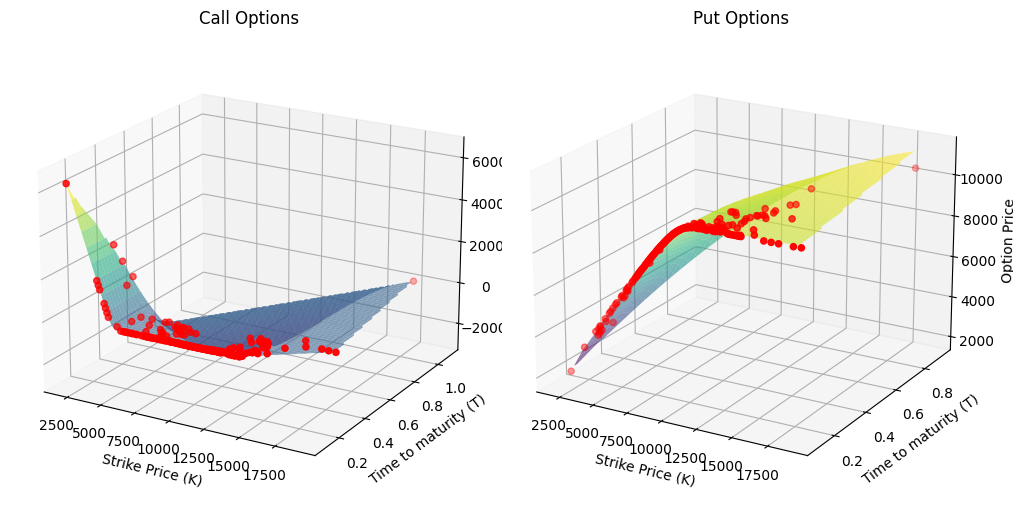

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

# Read the data
file_path = 'H93_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Calculate the market price for both call and put options
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Separate the data into call and put options
call_options = options_data[options_data['PUTCALLIND'] == 'CALL']
put_options = options_data[options_data['PUTCALLIND'] == 'PUT ']

# Define the variables for Strike Prices and Time to Maturity for calls and puts
K_call, T_call = call_options['STRIKE_PRC'].values, call_options['T'].values
K_put, T_put = put_options['STRIKE_PRC'].values, put_options['T'].values

# Create a mesh grid for T and K for calls and puts
K_grid_call, T_grid_call = np.meshgrid(np.linspace(min(K_call), max(K_call), 100), np.linspace(min(T_call), max(T_call), 100))
K_grid_put, T_grid_put = np.meshgrid(np.linspace(min(K_put), max(K_put), 100), np.linspace(min(T_put), max(T_put), 100))

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Create 3D plots for call options
ax1 = fig.add_subplot(121, projection='3d')
model_price_grid_call = griddata((K_call, T_call), call_options['MODEL_PRICE'], (K_grid_call, T_grid_call), method='cubic')
ax1.plot_surface(K_grid_call, T_grid_call, model_price_grid_call, cmap='viridis', alpha=0.6)
ax1.scatter(K_call, T_call, call_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax1.set_title('Call Options')
ax1.set_xlabel('Strike Price (K)')
ax1.set_ylabel('Time to maturity (T)')
ax1.set_zlabel('Option Price', rotation=90)
ax1.view_init(20, -60)  # Adjust the viewing angle for better visualization

# Create 3D plots for put options
ax2 = fig.add_subplot(122, projection='3d')
model_price_grid_put = griddata((K_put, T_put), put_options['MODEL_PRICE'], (K_grid_put, T_grid_put), method='cubic')
ax2.plot_surface(K_grid_put, T_grid_put, model_price_grid_put, cmap='viridis', alpha=0.6)
ax2.scatter(K_put, T_put, put_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax2.set_title('Put Options')
ax2.set_xlabel('Strike Price (K)')
ax2.set_ylabel('Time to maturity (T)')
ax2.set_zlabel('Option Price', rotation=90)
ax2.view_init(20, -60)  # Adjust the viewing angle for better visualization

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

# Read the data
file_path = 'H93_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Define a threshold for what is considered a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Extract relevant columns
result = options_data[['PUTCALLIND', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'OUTSIDE_THRESHOLD']]

print(result)

# Export the DataFrame to a CSV file
result.to_csv('H93_SLSQP_with_errors.csv', index=False)


    PUTCALLIND  IMP_VOLT  PERCENTAGE_ERROR  OUTSIDE_THRESHOLD
1         CALL     23.23               NaN              False
2         CALL     23.23               inf               True
3         CALL     23.25               NaN              False
4         CALL     23.26               NaN              False
5         CALL     23.32               inf               True
..         ...       ...               ...                ...
373       CALL    115.42          0.927737              False
374       CALL    118.17          2.421697              False
375       CALL    130.77          1.493155              False
376       PUT     150.50          0.686845              False
377       CALL    203.25          0.151906              False

[377 rows x 4 columns]


In [10]:
import numpy as np
import pandas as pd

# Read the data
file_path = 'H93_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Replace 'inf' percentage error with None for CALL options
options_data.loc[(options_data['PUTCALLIND'] == 'CALL') & (options_data['PERCENTAGE_ERROR'] == np.inf), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what is considered a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Count the number of 'CALL' and 'PUT' options within the threshold
num_calls_within_threshold = len(options_data[(options_data['PUTCALLIND'] == 'CALL') & (options_data['OUTSIDE_THRESHOLD'] == False)])
num_puts_within_threshold = len(options_data[(options_data['PUTCALLIND'] == 'PUT ') & (options_data['OUTSIDE_THRESHOLD'] == False)])

print(f"Number of CALL options within threshold: {num_calls_within_threshold}")
print(f"Number of PUT options within threshold: {num_puts_within_threshold}")


Number of CALL options within threshold: 188
Number of PUT options within threshold: 188


In [11]:
import pandas as pd
import plotly.express as px

# Read the data
file_path = 'H93_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Correct infinite percentage errors due to division by zero
options_data.loc[options_data['PERCENTAGE_ERROR'] == float('inf'), 'PERCENTAGE_ERROR'] = None

# Define a threshold for is considered a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Create a new column combining option type and threshold status
options_data['OPTION_STATUS'] = options_data.apply(lambda row: row['PUTCALLIND'].strip() + (' Outside' if row['OUTSIDE_THRESHOLD'] else ' Inside'), axis=1)

# Extract relevant columns
result = options_data[['OPTION_STATUS', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'MODEL_PRICE']]

# Create a scatter plot with facets
fig = px.scatter(result,
                 x='MODEL_PRICE',
                 y='IMP_VOLT',
                 color='PERCENTAGE_ERROR',
                 facet_col='OPTION_STATUS',
                 title='Option Prices vs. Implied Volatility',
                 labels={'MODEL_PRICE': 'Option Price', 'IMP_VOLT': 'Implied Volatility', 'OPTION_STATUS': 'Option Type & Status'},
                 color_continuous_scale='viridis',
                 hover_data=['OPTION_STATUS', 'PERCENTAGE_ERROR'])

# Modify the marker aesthetics
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Update facet titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

# Show the plot
fig.show()
